In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from datetime import datetime, timedelta

# Alerts data preprocessing
The following preprocessing is necessary to perform analysis afterwards

In [62]:
# Lines added to make dataframes with large number of columns get displayed in their entirety
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [63]:
df = pd.read_csv('../datasets/alerts_data.csv', index_col=False)

<ipython-input-63-3b425d876bd6>:1: DtypeWarning: Columns (24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/alerts_data.csv', index_col=False)


In [64]:
# converting time-based columns from type string to type timestamp
alerts_timedate_cols = ['alert_creation_timestamp', 'alert_first_triaged', 'alert_triage_due_date', 'alert_bug_due_date', 'alert_bug_updated']
for i in alerts_timedate_cols:
  df[i] = pd.to_datetime(df[i], format='%Y-%m-%dT%H:%M:%S.%f')
df['alert_push_timestamp'] = pd.to_datetime(df['alert_push_timestamp'], unit='s')
df.drop(columns=['test_series_signature_framework_id'], inplace=True)

In [65]:
alert_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "improvement",
    5: "investigating",
    6: "wontfix",
    7: "fixed",
    8: "backedout"
}
framework_mapping = {
    1: "talos",
    2: "build_metrics",
    4: "awsy",
    6: "platform_microbench",
    10: "raptor",
    11: "js-bench",
    12: "devtools",
    13: "browsertime",
    15: "mozperftest",
    16: "fxrecord"
}
test_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "acknowledged"
}

In [66]:
df['alert_framework'] = df['alert_framework'].map(framework_mapping)
df['alert_status'] = df['alert_status'].map(alert_status_mapping)
df['test_status'] = df['test_status'].map(test_status_mapping)

In [67]:
def get_dist_by_nb(dataf, cols):
  for col in cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataf, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

In [68]:
df.rename(columns={'test_series_signature_id': 'signature_id'}, inplace=True)

The following graph showcases that the great majority of signature are mentionned only once in the dataset

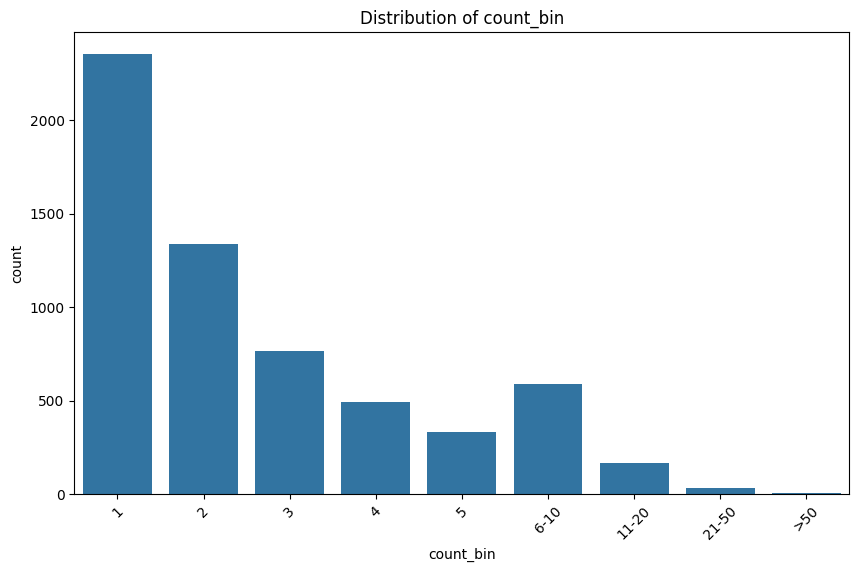

In [69]:
df_sig_dist = df.copy()
category_counts = df_sig_dist['signature_id'].value_counts()
bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, float('inf')]
labels = ['1', '2', '3', '4', '5', '6-10', '11-20', '21-50', '>50']
category_bins = pd.cut(category_counts, bins=bins, labels=labels, right=True)
category_bins_df = category_bins.reset_index()
category_bins_df.columns = ['signature_id', 'count_bin']
get_dist_by_nb(category_bins_df, ['count_bin'])

The following graph showcases the signature IDs occurring the most in the dataset (top 5)

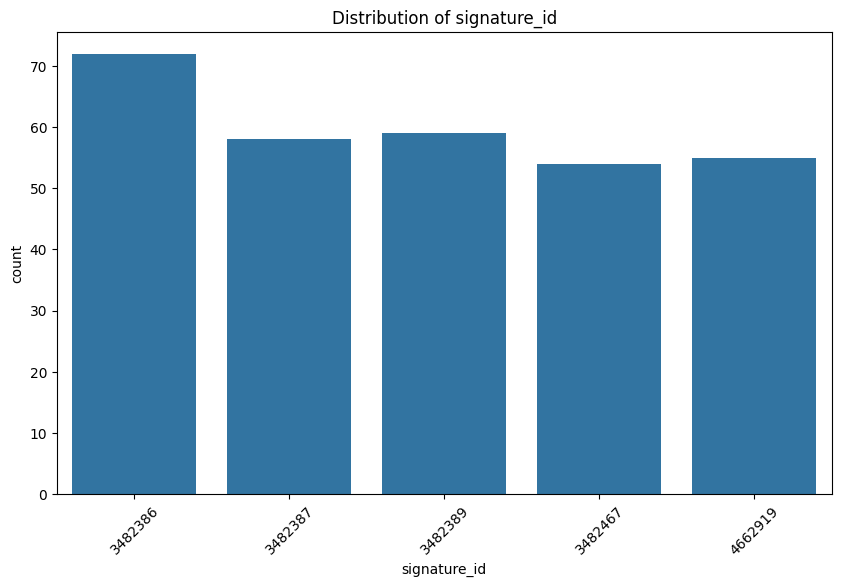

In [70]:
n = 5
top_n_categories = df['signature_id'].value_counts().nlargest(n).index
filtered_df = df[df['signature_id'].isin(top_n_categories)]
get_dist_by_nb(filtered_df, ['signature_id'])

In [71]:
most_frequent_signatures = [3482386, 3482387, 3482389, 3482467, 4662919]

The following showcases the top 3 signature IDs associated with true positive alerts

In [72]:
filtered_df = df[df['alert_status'].isin(["backedout", "fixed", "improvement"])]
sig_counts = filtered_df['signature_id'].value_counts()
top_3_sig = sig_counts.nlargest(3).index
result_df = filtered_df[filtered_df['signature_id'].isin(top_3_sig)]
print(result_df["signature_id"].value_counts())
top_tp_sig = [3779889, 3779886, 3891453]

signature_id
3779889    11
3779886    10
3891453    10
Name: count, dtype: int64


The following showcases the top 3 signature IDs associated with false positive alerts

In [73]:
filtered_df = df[df['alert_status'].isin(["wontfix", "invalid"])]
sig_counts = filtered_df['signature_id'].value_counts()
top_3_sig = sig_counts.nlargest(3).index
result_df = filtered_df[filtered_df['signature_id'].isin(top_3_sig)]
print(result_df["signature_id"].value_counts())
top_fp_sig = [2259234, 2680290, 4669835]

signature_id
2259234    30
2680290    19
4669835    17
Name: count, dtype: int64


In [74]:
def display_sample_2(dataf, sig_id, date_delta=None):
    sample_df = dataf.copy()
    #sample_df = sample_df[(sample_df["signature_id"] == sig_id) & (sample_df["alert_status"] != "TN")]
    sample_df = sample_df[sample_df["signature_id"] == sig_id]
    if date_delta:
        sample_df = sample_df[sample_df["push_timestamp"] > date_delta]
    sample_df.set_index('push_timestamp', inplace=True)
    plt.figure(figsize=(12, 8))
    color_mapping = {
        'TP': 'green',
        'FP': 'red',
        'SP': 'grey',
        'TN': 'blue'
    }
    for idx, row in sample_df.iterrows():
        plt.plot(idx, row['value'], marker='o', markersize=8, color=color_mapping.get(row['alert_status']), alpha=0.6)
    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel(f'Test measurement values associated with signature ID {sig_id}')
    plt.grid(True)
    plt.xlim(sample_df.index.min(), sample_df.index.max())
    plt.show()
'''
date_x_days_ago = datetime(2024, 5, 15) - timedelta(days=365)
print(4768977)
display_sample_2(df_final, 4768977, date_x_days_ago)

print(4768979)
display_sample_2(df_final, 4768979, date_x_days_ago)

print(4768980)
display_sample_2(df_final, 4768980, date_x_days_ago)

print(4769032)
display_sample_2(df_final, 4769032, date_x_days_ago)'''

'\ndate_x_days_ago = datetime(2024, 5, 15) - timedelta(days=365)\nprint(4768977)\ndisplay_sample_2(df_final, 4768977, date_x_days_ago)\n\nprint(4768979)\ndisplay_sample_2(df_final, 4768979, date_x_days_ago)\n\nprint(4768980)\ndisplay_sample_2(df_final, 4768980, date_x_days_ago)\n\nprint(4769032)\ndisplay_sample_2(df_final, 4769032, date_x_days_ago)'

In [75]:
def display_sample(dataf, sig_id, date_delta=None):
  sample_df = dataf.copy()
  sample_df = sample_df[sample_df["signature_id"] == sig_id]
  display(sample_df.head(5))
  if date_delta:
    sample_df = sample_df[sample_df["push_timestamp"] > date_delta]
    display(sample_df.head(5))
  sample_df.set_index('push_timestamp', inplace=True)
  plt.figure(figsize=(10, 6))
  plt.plot(sample_df.index, sample_df['value'], marker='o', linestyle='-')
  plt.title('Time Series Plot')
  plt.xlabel('Date')
  plt.ylabel('Test measurement values associated with signature ID ' + str(sig_id))
  plt.grid(True)
  plt.show()

In [76]:
df1 = pd.read_csv('../datasets/autoland4/3482386_timeseries_data.csv')
df2 = pd.read_csv('../datasets/autoland4/3482387_timeseries_data.csv')
df3 = pd.read_csv('../datasets/autoland4/3482389_timeseries_data.csv')
df4 = pd.read_csv('../datasets/autoland4/3482467_timeseries_data.csv')
df5 = pd.read_csv('../datasets/autoland2/4662919_timeseries_data.csv')
df6 = pd.read_csv('../datasets/autoland4/3779889_timeseries_data.csv')
df7 = pd.read_csv('../datasets/autoland4/3779886_timeseries_data.csv')
df8 = pd.read_csv('../datasets/mozilla-beta/3891453_timeseries_data.csv')
df9 = pd.read_csv('../datasets/autoland4/2259234_timeseries_data.csv')
df10 = pd.read_csv('../datasets/autoland4/2680290_timeseries_data.csv')
df11 = pd.read_csv('../datasets/firefox-android/4669835_timeseries_data.csv')
df12 = pd.read_csv('../datasets/autoland3/4375303_timeseries_data.csv')
df13 = pd.read_csv('../datasets/autoland4/3777127_timeseries_data.csv')
df14 = pd.read_csv('../datasets/autoland2/4405631_timeseries_data.csv')
timeseries_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14], ignore_index=True).drop_duplicates()
timeseries_df['push_timestamp'] = timeseries_df['push_timestamp'].str.replace("'", "", regex=False)
timeseries_df['push_timestamp'] = pd.to_datetime(timeseries_df['push_timestamp'], format='%Y-%m-%d %H:%M:%S')

<ipython-input-76-7c67cad6a787>:9: DtypeWarning: Columns (47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df9 = pd.read_csv('/content/2259234_timeseries_data.csv')
<ipython-input-76-7c67cad6a787>:10: DtypeWarning: Columns (47,49,76,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df10 = pd.read_csv('/content/2680290_timeseries_data.csv')


In [82]:
def print_unique_entries_count(dataf, unique_entry, col):
  print("Number of unique signatures associated with the " + str(unique_entry) + " value of column " + col)
  if (str(unique_entry) == "nan"):
    print(len(dataf[dataf[col].isnull()]["signature_id"].unique()))
  else:
    print(len(dataf[dataf[col] == unique_entry]["signature_id"].unique()))

In [83]:
for measure_unit in timeseries_df["measurement_unit"].unique():
  print_unique_entries_count(timeseries_df, measure_unit, "measurement_unit")

Number of unique signatures associated with the nan value of column measurement_unit
8
Number of unique signatures associated with the ms value of column measurement_unit
5
Number of unique signatures associated with the bytes value of column measurement_unit
1


In [84]:
print(list(set(timeseries_df.columns.tolist()) - set(df.columns.tolist())))
print(list(set(df.columns.tolist()) - set(timeseries_df.columns.tolist())))

['test_series_signature_framework_id', 'application', 'push_timestamp', 'option_collection_hash', 'value', 'lower_is_better', 'repository_name', 'name', 'measurement_unit', 'revision', 'framework_id', 'should_alert', 'push_id', 'repository_id', 'entry_id', 'extra_options', 'has_subtests', 'job_id', 'test', 'tags', 'signature_hash', 'parent_signature', 'machine_platform', 'suite']
['alert_revision']


In [85]:
common_columns = list(set(df.columns).intersection(set(timeseries_df.columns)) - {'revision', 'alert_revision', 'signature_id', 'alert_revision'})
timeseries_df_extended = timeseries_df.drop(columns=common_columns)
df_merged = pd.merge(timeseries_df_extended, df, left_on=['revision', 'signature_id'], right_on=['alert_revision', 'signature_id'], how='left', suffixes=('', ''))
df_merged['alert_status'].fillna('TN', inplace=True)
df_final = df_merged.drop_duplicates()
df_final.drop(columns=['alert_revision'], inplace=True)

In [86]:
category_mapping = {
    'investigating': 'SP', # 'SP' stands for 'Still Processing'
    'reassigned': 'SP',
    'invalid': 'FP',
    'improvement': 'TP',
    'fixed': 'TP',
    'wontfix': 'FP',
    'untriaged': 'SP',
    'backedout': 'TP'
}
df_final["alert_status"] = df_final["alert_status"].replace(category_mapping)

In [87]:
category_counts = df_sig_dist['signature_id'].value_counts()
average_count = category_counts.mean()
median_count = category_counts.median()
print(f"Signatures average count: {average_count:.2f}")
print(f"Signatures median count: {median_count:.2f}")

Signatures average count: 3.12
Signatures median count: 2.00


The following represents the distribution of the alert statuses across the selected signatures

In [88]:
percentage_counts = df_final['alert_status'].value_counts(normalize=True) * 100
print(percentage_counts)

alert_status
TN    98.982325
SP     0.648835
FP     0.258457
TP     0.110383
Name: proportion, dtype: float64


In [89]:
df_final["alert_status"] = df_final["alert_status"].replace(category_mapping)

KeyError: 'alert_status'

In [ ]:
date_one_year_ago = datetime(2024, 5, 15) - timedelta(days=365)
def display_sig_characteristics(sig_id):
  display_sample_2(df_final, sig_id, date_one_year_ago)
  subject_sig_df = df_final[df_final['signature_id'] == sig_id]
  percentage_counts = subject_sig_df['alert_status'].value_counts(normalize=True) * 100
  print(percentage_counts)

The following visualization is consisted of timeseries plots as well as alert status distribution for most occurring signatures in the alerts during the last year

In [ ]:
for sig in most_frequent_signatures:
  print("characteristics of signature ID " + str(sig))
  display_sig_characteristics(sig)

The following visualization is consisted of timeseries plots as well as alert status distribution for signatures associated with true positive alerts the most

In [ ]:
for sig in top_tp_sig:
  print("characteristics of signature ID " + str(sig))
  display_sig_characteristics(sig)

The following visualization is consisted of timeseries plots as well as alert status distribution for signatures associated with false positive alerts the most

In [ ]:
for sig in top_fp_sig:
  print("characteristics of signature ID " + str(sig))
  display_sig_characteristics(sig)